In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import regex as re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Oversampling
from imblearn.over_sampling import RandomOverSampler

# TensorFlow and Keras

import tensorflow as tf
from tensorflow.keras import layers, models

# models

from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics 

You should download the data here: https://drive.google.com/file/d/1NBmEC99-XsEUihKelFv86puT9zkO3ulv/view?usp=sharing

In [8]:
path = r'./nuovi_dati_SDSS_Gal_z_0.05-0.06/sample1/GALAXY_z_0.05-0.06_SAMPLE1_ASCII/' # use your path
all_files = glob.glob(os.path.join(path , "*.txt"))

In [10]:
# Number of files in the folder
print(len(all_files))

8134


In [73]:
print(all_files[0])
m = re.search(r"^.*_\K[^.]+", all_files[0])
m[0]

./nuovi_dati_SDSS_Gal_z_0.05-0.06/sample1/GALAXY_z_0.05-0.06_SAMPLE1_ASCII/spec-0714-52201-0149_SF.txt


'SF'

In [34]:
columns = ['lambda', 'flux', 'error']
df_tmp = pd.read_csv(all_files[0], skiprows=1, sep = ' ', names = columns)
df_tmp.head()

,lambda,flux,error
0,3700,24.5856,2.41859
1,3702,24.9272,2.44588
2,3704,22.6299,2.41245
3,3706,24.4782,2.48300
4,3708,24.8940,2.51567


In [212]:
# Note we select only SF, COMP, AGN

data = []
labels = []
for f in all_files:
    df_tmp = pd.read_csv(f, skiprows=1, sep = ' ', names = columns)
    label_ = re.search(r"^.*_\K[^.]+", f)[0]
    
    
    if (label_ in ['SF', 'COMP', 'AGN']):
        labels.append(label_)
        data.append(np.array(df_tmp['flux'])) # An element of the list will be a numpy array
#df = pd.concat((pd.read_csv(f, header = 1) for f in all_files), ignore_index=True)

In [213]:
print(len(data))
print(len(labels))

6092
6092


In [319]:
# Let's encode the labels.
le = preprocessing.LabelEncoder()
le.fit(labels)
# Available classes
print(le.classes_)
# We save the encoded labels in a list
encoded_labels = le.transform(labels)

# Note that the dataset is clearly unbalanced
print(np.unique(labels, return_counts=True))

['AGN' 'COMP' 'SF']
(array(['AGN', 'COMP', 'SF'], dtype='<U4'), array([ 438,  875, 4779]))


In [215]:
data[0:5]

[array([24.5856, 24.9272, 22.6299, ..., 19.2108, 20.8883, 19.503 ]),
 array([7.32436, 6.70572, 4.79029, ..., 5.61146, 4.68844, 6.76231]),
 array([13.2928 , 12.8739 , 18.872  , ...,  9.27521,  7.88111,  7.6821 ]),
 array([5.27856, 3.74735, 7.3442 , ..., 3.13829, 2.91796, 2.9902 ]),
 array([7.10913, 6.43314, 6.84874, ..., 6.35289, 5.71914, 5.88743])]

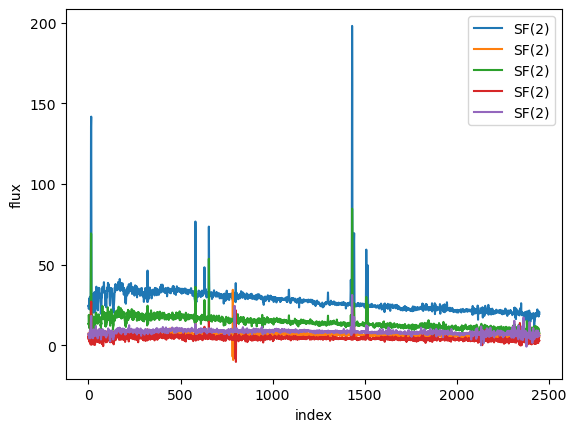

In [216]:
for i in range(5):
    plt.plot(data[i], label = labels[i]+'('+str(encoded_labels[i])+')')
plt.xlabel('index')
plt.ylabel('flux')
plt.legend()
plt.show()

## Hold-out approach (data splitting)

In [ ]:
# we normalise the data
data_norm = np.array([d/1000 for d in data])
print(data_norm.shape)


# we split the data
X_train, X_test, y_train, y_test = train_test_split(
    data_norm, encoded_labels, test_size=0.2, random_state=42)

print(X_train.shape)

# We check the maximum value of the data
print(np.max(X_train))

## Modelling

In [305]:
clf = AdaBoostClassifier()
clf.fit(X_train,y_train)

AdaBoostClassifier()

In [307]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8802296964725185


In [308]:
confusion_matrix(y_test, y_pred)

array([[ 49,  36,   1],
       [ 13,  96,  45],
       [  2,  49, 928]])

## Neural Network

In [310]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', input_shape = [2450]),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

In [311]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [312]:
history = model.fit(X_train, y_train, epochs=200, validation_data= (X_test, y_test), verbose = 0)

2024-01-04 19:29:43.160617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-04 19:29:46.446818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


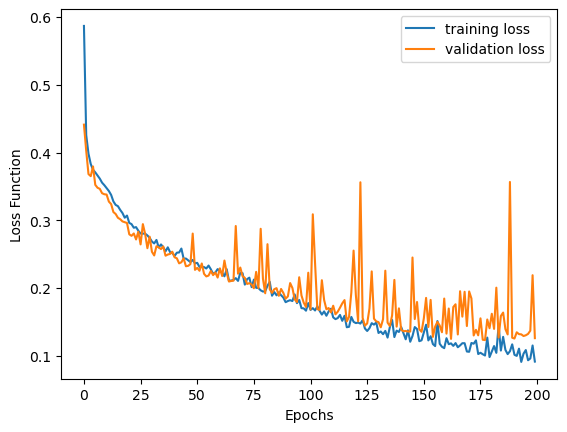

In [313]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

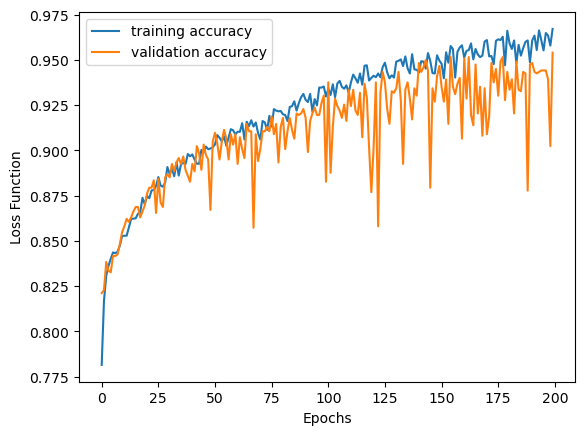

In [317]:
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

In [314]:
preds = np.argmax(model.predict(X_test), axis = 1)
confusion_matrix(y_test, preds)

2024-01-04 19:33:19.163584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 8ms/step


array([[ 73,  13,   0],
       [  5, 138,  11],
       [  0,  27, 952]])

In [315]:
print("Accuracy:",metrics.accuracy_score(y_test, preds))

Accuracy: 0.9540607054963085


In [316]:
print(model.evaluate(X_test, y_test))
print(model.evaluate(X_train, y_train))

39/39 [==============================] - 0s 5ms/step - loss: 0.1259 - accuracy: 0.9541
[0.1259404867887497, 0.9540607333183289]
153/153 [==============================] - 1s 8ms/step - loss: 0.0806 - accuracy: 0.9737
[0.08056847006082535, 0.9737328290939331]


## 1-D Convolutional Neural Network

In [290]:
# create model
model = tf.keras.Sequential()
model.add(layers.Conv1D(6, 15, activation = 'relu', input_shape = (2450,1)))
model.add(layers.MaxPooling1D(pool_size = (2), strides = (2)))
model.add(layers.Conv1D(3, 15, strides = 1, activation = 'relu'))
model.add(layers.MaxPooling1D(pool_size = 2, strides = 2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))
# compile model
model.compile(loss = 'SparseCategoricalCrossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [291]:
# We need to add a "fake" dimension to the data (the channel)
X_train_CNN = X_train[:,:, np.newaxis]
X_test_CNN = X_test[:,:, np.newaxis]

In [292]:
history = model.fit(X_train_CNN, y_train, epochs=50, validation_data= (X_test_CNN, y_test), verbose = 0)

2024-01-04 19:23:23.584566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-04 19:23:29.013891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


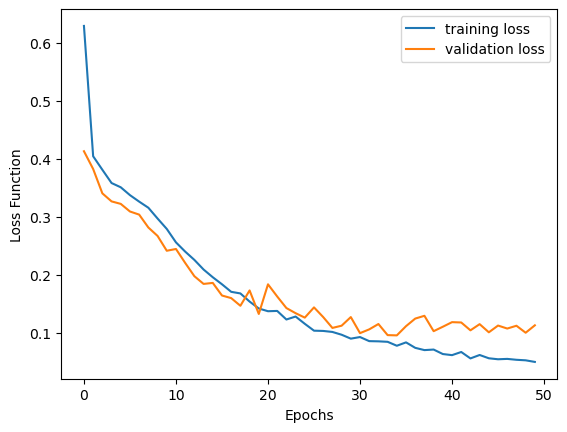

In [297]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

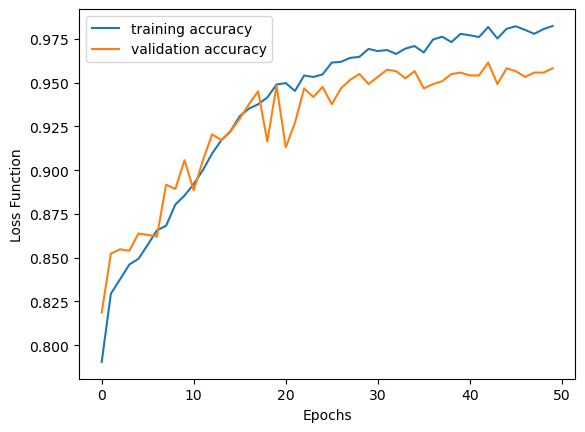

In [304]:
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

In [298]:
preds = np.argmax(model.predict(X_test), axis = 1)
confusion_matrix(y_test, preds)

39/39 [==============================] - 0s 3ms/step


array([[ 77,   9,   0],
       [ 10, 137,   7],
       [  0,  25, 954]])

In [299]:
print("Accuracy:",metrics.accuracy_score(y_test, preds))

Accuracy: 0.9581624282198523


In [300]:
print(model.evaluate(X_test_CNN, y_test))
print(model.evaluate(X_train_CNN, y_train))

39/39 [==============================] - 0s 6ms/step - loss: 0.1133 - accuracy: 0.9582
[0.11333000659942627, 0.9581624269485474]
153/153 [==============================] - 1s 6ms/step - loss: 0.0392 - accuracy: 0.9887
[0.03915872797369957, 0.9887133240699768]


# Oversampling

In [326]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# We need to add a "fake" dimension to the data (the channel)
X_resampled_CNN = X_resampled[:,:, np.newaxis]

In [327]:
# create model
model = tf.keras.Sequential()
model.add(layers.Conv1D(6, 15, activation = 'relu', input_shape = (2450,1)))
model.add(layers.MaxPooling1D(pool_size = (2), strides = (2)))
model.add(layers.Conv1D(3, 15, strides = 1, activation = 'relu'))
model.add(layers.MaxPooling1D(pool_size = 2, strides = 2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))
# compile model
model.compile(loss = 'SparseCategoricalCrossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [329]:
history = model.fit(X_resampled_CNN, y_resampled, epochs=50, validation_data= (X_test_CNN, y_test), verbose = 0)

2024-01-04 19:39:45.517969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-04 19:39:53.096436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


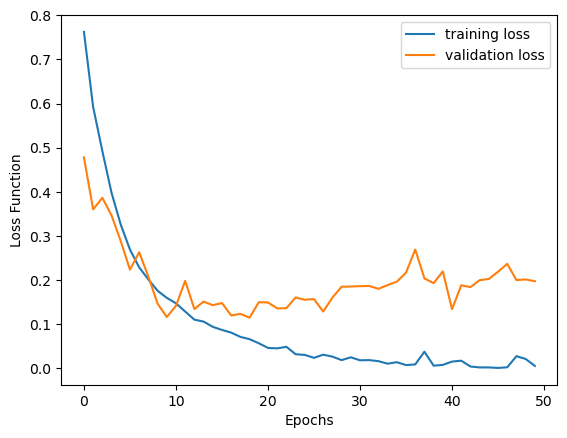

In [330]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

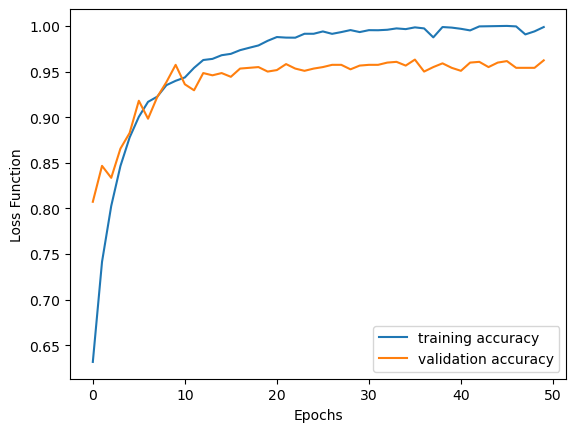

In [331]:
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

In [332]:
preds = np.argmax(model.predict(X_test), axis = 1)
confusion_matrix(y_test, preds)

2024-01-04 19:42:36.281492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 15ms/step


array([[ 73,  13,   0],
       [  6, 135,  13],
       [  0,  14, 965]])

In [333]:
print("Accuracy:",metrics.accuracy_score(y_test, preds))

Accuracy: 0.9622641509433962


In [334]:
print(model.evaluate(X_test_CNN, y_test))
print(model.evaluate(X_train_CNN, y_train))

39/39 [==============================] - 0s 6ms/step - loss: 0.1977 - accuracy: 0.9623
[0.1976562738418579, 0.9622641801834106]
153/153 [==============================] - 2s 11ms/step - loss: 0.0020 - accuracy: 0.9998
[0.001979211810976267, 0.9997947812080383]
